In [11]:
import sys
sys.path.append("../scripts")

import os, torch
from sklearn.model_selection import train_test_split
import pickle
import torch_geometric.transforms as T
import numpy as np
from torch_geometric.nn.models import Node2Vec
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
GCNConv._orig_propagate = GCNConv.propagate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch_geometric.explain import GNNExplainer, Explainer
from models import *
from tg_functions import *
from bike_functions import *

dropout_p = 0.5
use_gat = True
bins = [int(i) for i in os.getenv("BINS", "400 800 1300 2100 3000 3700 4700 7020 9660").split(' ')]
bins = torch.tensor(bins, device='cuda' if torch.cuda.is_available() else 'cpu')
# bins = 'regression'
hidden_c = 200
num_layers = 0
random_seed = 100
nh = 1

graph_num = 17  # Replace with your graph number

model_name = 'rich-sun-141' # Replace with your model name

weight_prefix = 'best_accuracy'  # Replace with your weight prefix



if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}", flush = True)
else:
    device = torch.device('cpu')
    print("Using CPU", flush = True)

# device = 'cpu'

with open(f'../data/graphs/{graph_num}/linegraph_tg.pkl', 'rb') as f:
    data = pickle.load(f)

data.edge_index = data.edge_index.contiguous()
data.x = data.x.contiguous()
data.y = data.y.contiguous()

data = stratified_split(data = data , random_seed = random_seed)

# --- Model Instantiation ---
model = GAT(hidden_c, num_layers, random_seed, bins, data, nh).to(device) if use_gat else GCN(hidden_c, num_layers, random_seed, bins, data).to(device)

if use_gat == 'MLP':
    model = MLP(hidden_c, num_layers, random_seed, bins, data, nh).to(device)

# Load the model with the GCN class
model = torch.load(f'../data/graphs/{graph_num}/models/{model_name}.pt', map_location=device)
model = model.to(device)

model.load_state_dict(torch.load(f'../data/graphs/{graph_num}/models/{model_name}_{weight_prefix}.pt', map_location=device))

criterion = torch.nn.CrossEntropyLoss()

/Users/christianrasmussen/opt/miniconda3/envs/newpyg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using CPU


In [12]:
data.edge_index = data.edge_index.contiguous()
data.x = data.x.contiguous()
data.y = data.y.contiguous()
print(data.x.shape, data.edge_index.shape, data.y.shape, flush = True)
data = stratified_split(data)
criterion = torch.nn.CrossEntropyLoss()


torch.Size([78168, 31]) torch.Size([2, 152596]) torch.Size([78168])


In [13]:
from torch_geometric.explain import GNNExplainer, Explainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=1),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=dict(
        mode='multiclass_classification',
        # mode='regression',
        task_level='node',
        return_type='log_probs',
        # return_type='raw_scores',
    ),
)


In [14]:
mask = data.val_mask.squeeze() & (data.y > 0).squeeze()
node_idx = torch.nonzero(mask, as_tuple=True)[0]


In [15]:
out = model(data.x.to(device), data.edge_index.to(device))
pred = out.argmax(dim=1)


In [16]:
value_to_column = build_value_to_column_dict()

📂 Found existing 'osm_value_to_column.json', loading dictionary...
✅ Loaded 865 value-to-column pairs from 'osm_value_to_column.json'.


In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Assume 'graph_num', 'node_idx', 'data', 'model', 'explainer' already exist

# Load feature names
feats_df = pd.read_csv(f'../data/graphs/{graph_num}/node_features.csv')
if 'aadt' in feats_df.columns:
    feats_df = feats_df.drop(columns=['aadt'])
if 'osmid' in feats_df.columns:
    feats_df = feats_df.drop(columns=['osmid'])


# Your secondary to primary mapping
secondary_to_primary = {
    # [your dictionary here]
}

# Initialize storage
scores = {}       # Collect importance scores
gradients = {}    # Collect target class gradients
all_bin_grads_total = {}  # Collect all bin gradients

data_x = data.x.to(device)
edge_index = data.edge_index.to(device)
data_y = data.y.to(device)

data_x.requires_grad_(True)

for idx in node_idx:
    # 1. Explain the node
    explanation = explainer(data_x, edge_index, index=idx)
    node_mask = explanation.node_mask.squeeze()

    # 2. Prediction and true label
    curr_pred = pred[idx].item()
    target = int(torch.bucketize(data_y[idx], bins.to(data_y.device)))

    # 3. Importance scores (all features)
    score = node_mask.sum(dim=0).detach().cpu().numpy().flatten()

    # 4. Per-bin gradients
    node_bin_grads = []
    for bin_idx in range(model(data_x, edge_index).shape[1]):
        model.zero_grad()
        out = model(data_x, edge_index)
        out[idx, bin_idx].backward(retain_graph=True)
        grad = data_x.grad[idx].detach().cpu().numpy().flatten()
        node_bin_grads.append(grad)
        data_x.grad.zero_()
    node_bin_grads = np.stack(node_bin_grads)  # (num_bins, num_features)

    # 5. Save gradients for **all features**
    for feat_idx in range(node_bin_grads.shape[1]):
        if feat_idx not in all_bin_grads_total:
            all_bin_grads_total[feat_idx] = []
        all_bin_grads_total[feat_idx].append(node_bin_grads[:, feat_idx])

        if feat_idx not in scores:
            scores[feat_idx] = []
            gradients[feat_idx] = []
        
        scores[feat_idx].append(score[feat_idx])
        gradients[feat_idx].append(node_bin_grads[target, feat_idx])  # Use target class gradient

# =====================================
# Convert all_bin_grads_total into a clean DataFrame
# =====================================

# Build a dictionary ready for DataFrame
feature_bin_gradient_dict = {}

for feat_idx, grads_list in all_bin_grads_total.items():
    feature_name = feats_df.columns[feat_idx]
    
    # Average across nodes per bin
    grads_across_nodes = np.stack(grads_list)  # (num_nodes, num_bins)
    avg_gradients = grads_across_nodes.mean(axis=0)  # (num_bins,)

    feature_bin_gradient_dict[feature_name] = avg_gradients

# Convert to DataFrame
feature_bin_gradients_df = pd.DataFrame.from_dict(
    feature_bin_gradient_dict, 
    orient='index', 
    columns=[f"Bin_{i}" for i in range(len(bins)+1)]
)

feature_bin_gradients_df.index.name = 'Feature'

In [18]:
# ================================
# After all nodes are explained
# ================================

# Sort by feature index
sorted_gradients = dict(sorted(gradients.items(), key=lambda item: item[0]))

# Map feature index → feature name
sorted_gradients_named = {feats_df.columns[k]: v for k, v in sorted_gradients.items()}

# Average importance score
average_gradients = {feat: np.mean(values) for feat, values in sorted_gradients_named.items()}

# =====================================
# Fit real Linear Regression (gradients vs bin index)
# =====================================

feature_slopes = {}
bin_indices = np.arange(len(bins)+1).reshape(-1, 1)  # 10 bins (0-9)

for feat_idx, feat_name in enumerate(feats_df.columns):
    if feat_idx not in all_bin_grads_total:
        continue

    # Stack across all explained nodes
    grads_across_nodes = np.stack(all_bin_grads_total[feat_idx])  # (num_nodes, num_bins)
    avg_grads_across_bins = np.mean(grads_across_nodes, axis=0)

    reg = LinearRegression().fit(bin_indices, avg_grads_across_bins)
    feature_slopes[feat_name] = reg.coef_[0]

# =====================================
# Build final DataFrame
# =====================================

summary_df = pd.DataFrame({
    'Feature': list(average_gradients.keys()),
    'Avg_Gradient': list(average_gradients.values()),
    'Gradient_Trend_Slope': [feature_slopes.get(feat, 0.0) for feat in average_gradients.keys()]
})

summary_df['Abs_Avg_Gradient'] = summary_df['Avg_Gradient'].abs()

# Group features based on secondary_to_primary
def map_primary(feature_name):
    return value_to_column.get(feature_name, feature_name)  # default to 'Other' if not found

summary_df['Primary_Category'] = summary_df['Feature'].apply(map_primary)

# # Sort by Primary Category then by Absolute Gradient
# summary_df = summary_df.sort_values(['Primary_Category', 'Abs_Avg_Gradient'], ascending=[True, False])

# # Save final output
# summary_df.to_csv('feature_gradients_grouped_by_primary.csv', index=False)

print("Saved grouped feature summary to 'feature_gradients_grouped_by_primary.csv'")
print(summary_df.head(15))  # Show first few rows


Saved grouped feature summary to 'feature_gradients_grouped_by_primary.csv'
     Feature  Avg_Gradient  Gradient_Trend_Slope  Abs_Avg_Gradient  \
0      lanes  8.807206e-02          1.851432e-02      8.807206e-02   
1   maxspeed -2.389708e-02          3.359450e-03      2.389708e-02   
2     oneway  3.487452e-02          1.986983e-02      3.487452e-02   
3   reversed  1.022025e-03         -2.695506e-03      1.022025e-03   
4     length -3.424853e-03         -7.227946e-04      3.424853e-03   
5         bc -1.989862e-07          1.860472e-07      1.989862e-07   
6    natural -1.143820e-02          6.013929e-03      1.143820e-02   
7   military  4.489966e-02          2.107433e-02      4.489966e-02   
8    barrier  2.375308e-02          2.106837e-02      2.375308e-02   
9       shop  8.836436e-02          2.406045e-02      8.836436e-02   
10  building  1.453214e-02         -3.062151e-03      1.453214e-02   
11   service  9.105648e-03         -4.703533e-03      9.105648e-03   
12   aeroway -

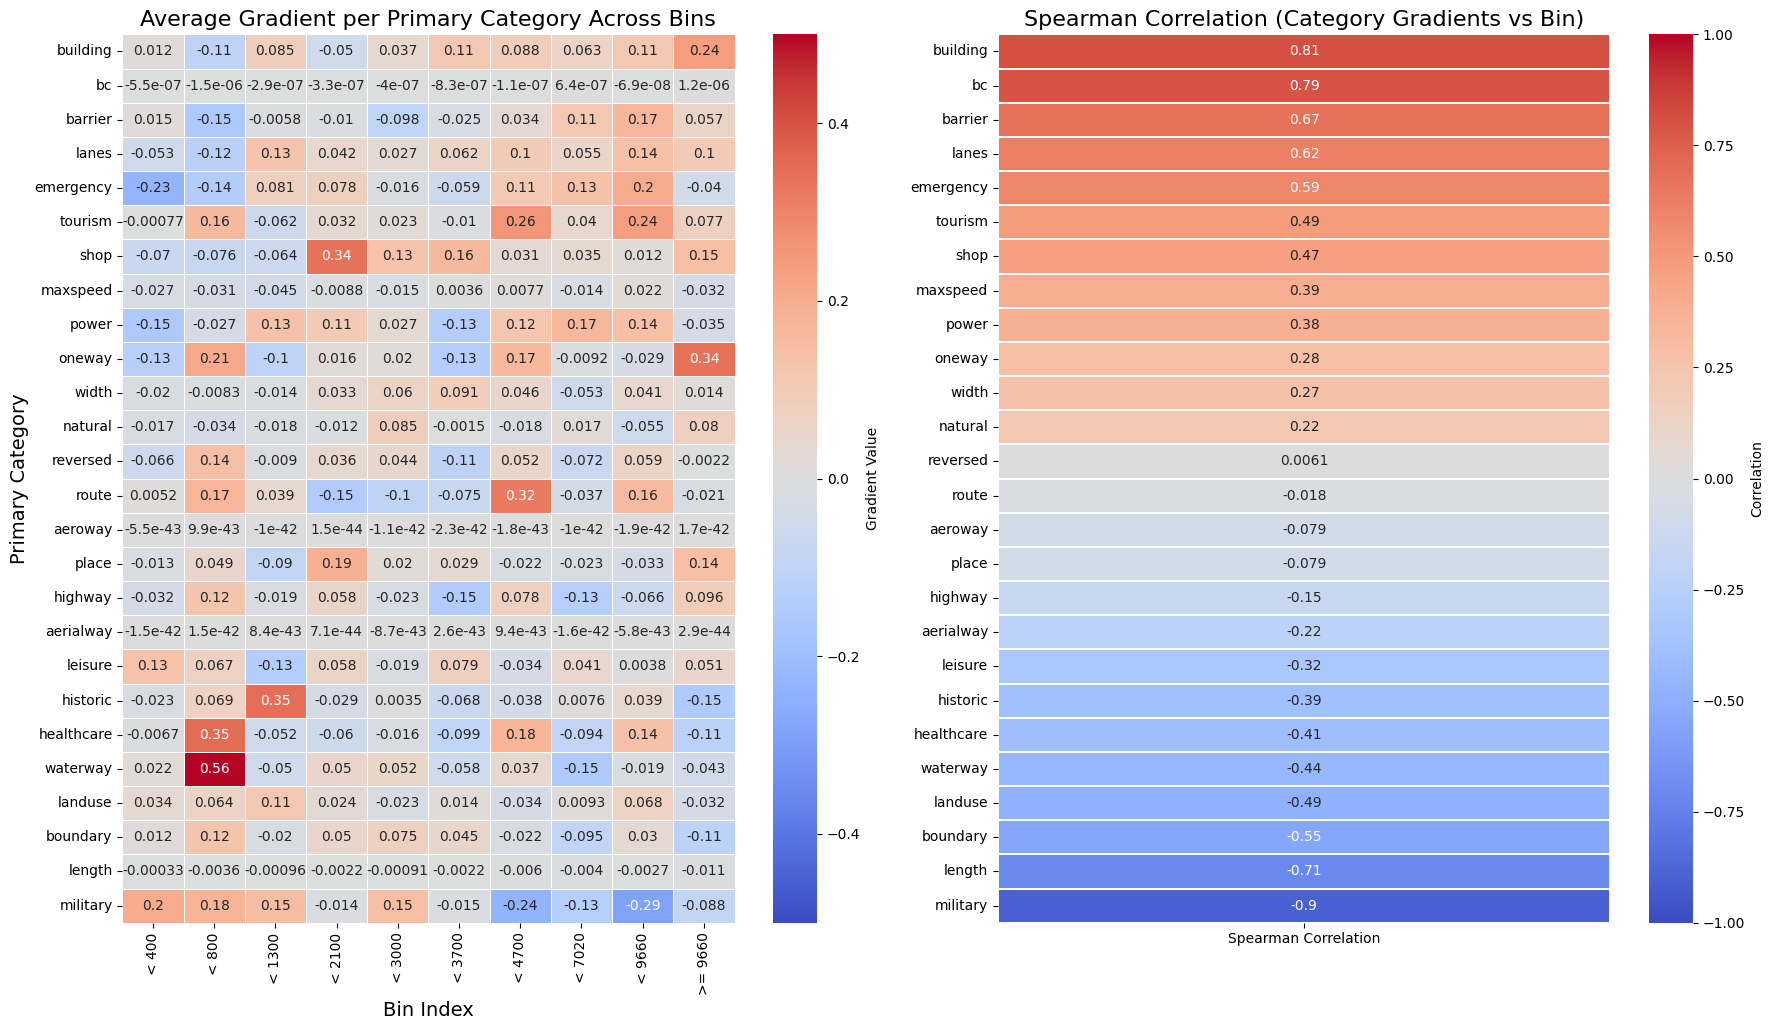

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# Step 1: Prepare the grouped summary_df
summary_grouped = summary_df.groupby('Primary_Category').agg({
    'Avg_Gradient': 'mean',
    'Gradient_Trend_Slope': 'mean'
}).sort_values('Avg_Gradient', ascending=False)

primary_categories = list(summary_grouped.index)

# Step 2: Build grouped feature × bin matrix

# Initialize matrix (Primary Categories x Bins)
category_bin_gradients = np.zeros((len(primary_categories), len(bins) + 1))

for idx, category in enumerate(primary_categories):
    # Find all features belonging to this category
    features_in_cat = summary_df[summary_df['Primary_Category'] == category]['Feature'].values

    # For each feature, accumulate its bin gradients
    grads_list = []
    for feat_name in features_in_cat:
        feat_idx_in_feats_df = list(feats_df.columns).index(feat_name)
        if feat_idx_in_feats_df not in all_bin_grads_total:
            continue

        grads_across_nodes = np.stack(all_bin_grads_total[feat_idx_in_feats_df])  # (num_nodes x num_bins)
        avg_grads_per_bin = np.mean(grads_across_nodes, axis=0)  # (num_bins,)
        grads_list.append(avg_grads_per_bin)

    # Average over all features in the category
    if grads_list:
        grads_list = np.stack(grads_list)
        category_bin_gradients[idx, :] = grads_list.mean(axis=0)

# Step 3: Compute Spearman correlation per category

spearman_corrs = []

for idx in range(category_bin_gradients.shape[0]):
    grads = category_bin_gradients[idx, :]
    bin_indices = np.arange(len(bins) + 1)

    if np.all(grads == 0):
        spearman_corr = 0.0
    else:
        spearman_corr, _ = spearmanr(bin_indices, grads)

    spearman_corrs.append(spearman_corr)

spearman_corrs = np.array(spearman_corrs)

order = np.argsort(spearman_corrs)[::-1]
primary_categories = np.array(primary_categories)[order]
category_bin_gradients = category_bin_gradients[order, :]
spearman_corrs = spearman_corrs[order]

# Step 4: Plot side-by-side

fig, axes = plt.subplots(1, 2, figsize=(18, len(primary_categories) * 0.4))

xtick_labels = [f'< {int(i)}' for i in bins.tolist()] 
xtick_labels.append(f'>= {bins[-1]}')

# Left: Gradients heatmap
sns.heatmap(
    category_bin_gradients,
    ax=axes[0],
    xticklabels=xtick_labels,
    yticklabels=primary_categories,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Gradient Value"},
    vmin=-0.5,
    vmax=0.5,
    annot=True,
)
axes[0].set_title("Average Gradient per Primary Category Across Bins", fontsize=16)
axes[0].set_xlabel("Bin Index", fontsize=14)
axes[0].set_ylabel("Primary Category", fontsize=14)

# Right: Spearman correlation heatmap
sns.heatmap(
    spearman_corrs.reshape(-1, 1),
    ax=axes[1],
    yticklabels=primary_categories,
    xticklabels=["Spearman Correlation"],
    cmap="coolwarm",
    center=0,
    linewidths=0.2,
    cbar_kws={"label": "Correlation"},
    vmin=-1,
    vmax=1,
    annot=True,
)
axes[1].set_title("Spearman Correlation (Category Gradients vs Bin)", fontsize=16)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_73661/3175560410.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


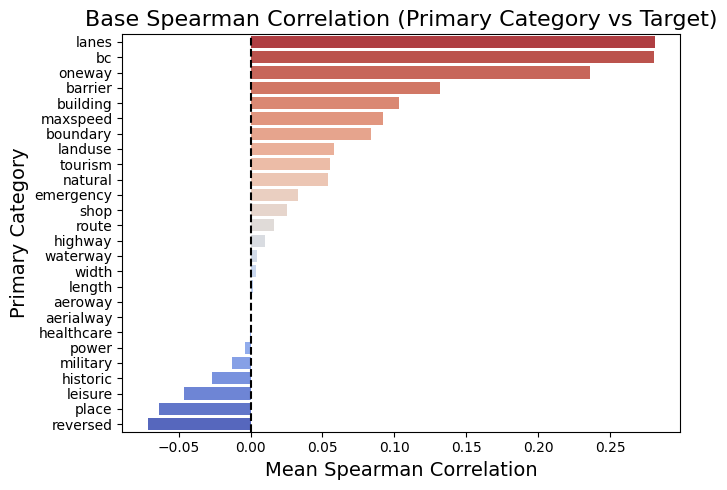

In [20]:
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Step 1: Prepare features and y

# Load feature data
X = pd.read_csv(f'../data/graphs/{graph_num}/node_features.csv')
if 'aadt' in X.columns:
    X = X.drop(columns=['aadt'])
if 'osmid' in X.columns:
    X = X.drop(columns=['osmid'])
y = data.y.cpu().numpy()  # Your original target values (unbinned)

# 🧠 Step 2: Mask X and y where y > 0
mask = y > 0
X_filtered = X.iloc[mask]
y_filtered = y[mask]

# 🧠 Step 3: Compute Spearman correlation for each feature vs. y_filtered
base_spearman_corrs = {}

for feat in X_filtered.columns:
    feature_values = X_filtered[feat].values

    if np.all(feature_values == feature_values[0]):
        corr = 0.0
    else:
        corr, _ = spearmanr(feature_values, y_filtered)

    base_spearman_corrs[feat] = corr

# 🧠 Step 4: Convert to DataFrame
base_corr_df = pd.DataFrame({
    'Feature': list(base_spearman_corrs.keys()),
    'Spearman_Feature_vs_Target': list(base_spearman_corrs.values())
})

# 🧠 Step 5: Merge in Primary Category information

# Assume you already have `summary_df` with Feature and Primary_Category
base_corr_df = base_corr_df.merge(summary_df[['Feature', 'Primary_Category']], on='Feature', how='left')

# 🧠 Step 6: Group by Primary Category
base_corr_grouped = base_corr_df.groupby('Primary_Category').agg({
    'Spearman_Feature_vs_Target': 'mean'
}).sort_values('Spearman_Feature_vs_Target', ascending=False)

base_corr_grouped['Abs_Spearman'] = base_corr_grouped['Spearman_Feature_vs_Target'].abs()

# 🧠 Step 7: Plot

plt.figure(figsize=(7, 5))  # Scale by number of groups

sns.barplot(
    data=base_corr_grouped.reset_index(),
    y='Primary_Category',
    x='Spearman_Feature_vs_Target',
    palette='coolwarm_r',
)

plt.axvline(0, color='black', linestyle='--')
plt.title('Base Spearman Correlation (Primary Category vs Target)', fontsize=16)
plt.xlabel('Mean Spearman Correlation', fontsize=14)
plt.ylabel('Primary Category', fontsize=14)
plt.tight_layout()
plt.show()


/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_73661/2980969599.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


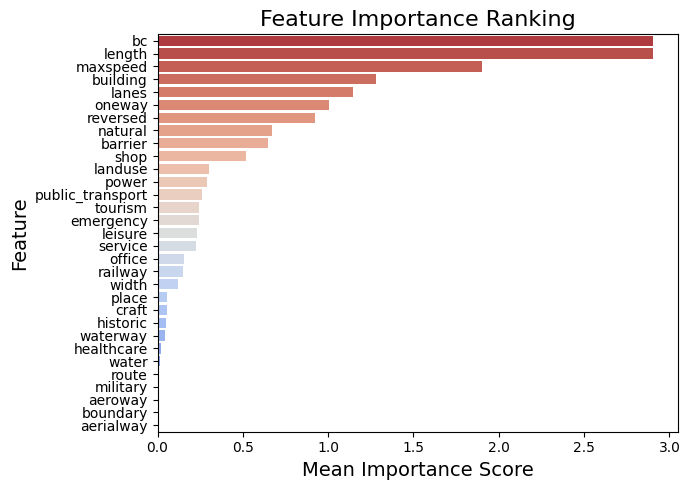

In [21]:
def get_feature_importance_ranking(scores_dict, feats_df, top_k=None, as_dataframe=True):
    """
    Maps feature indices to names and aggregates their importance scores.

    Args:
        scores_dict (dict): Dictionary of {feature_index: [importance scores]}.
        feats_df (pd.DataFrame): DataFrame with original features (columns are feature names).
        top_k (int or None): If set, only return top-k most important features.
        as_dataframe (bool): If True, returns a sorted DataFrame. If False, returns a dict.

    Returns:
        pd.DataFrame or dict: Ranked feature importance summary.
    """
    import pandas as pd
    import numpy as np

    # Aggregate scores (e.g., mean importance per feature)
    summary = {
        feats_df.columns[k]: np.mean(v)
        for k, v in scores_dict.items()
        if k < len(feats_df.columns)
    }

    # Sort descending by importance
    sorted_items = sorted(summary.items(), key=lambda x: abs(x[1]), reverse=True)

    if top_k:
        sorted_items = sorted_items[:top_k]

    if as_dataframe:
        return pd.DataFrame(sorted_items, columns=['Feature', 'Avg_Importance'])
    else:
        return dict(sorted_items)

ranking_df = get_feature_importance_ranking(scores, feats_df, top_k=100)
# display(ranking_df)

plt.figure(figsize=(7, 5))  # Scale by number of groups

sns.barplot(
    data=ranking_df,
    y='Feature',
    x='Avg_Importance',
    palette='coolwarm_r',
)

# plt.axvline(0, color='black', linestyle='--')
plt.title('Feature Importance Ranking', fontsize=16)
plt.xlabel('Mean Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
import torch
import numpy as np
import pandas as pd

def collect_regression_feature_gradients(graph_num, data, node_idx, model, explainer, pred, device):
    # Load feature names
    feats_df = pd.read_csv(f'../data/graphs/{graph_num}/node_features.csv')
    feats_df = feats_df.drop(columns=[col for col in ['aadt', 'osmid'] if col in feats_df.columns])

    # Initialize storage
    scores = {}       # Importance scores from GNNExplainer
    gradients = {}    # Gradients w.r.t. prediction (single target)
    all_node_grads_total = {}  # Raw gradients across all nodes (per feature)

    # Move data to device
    data_x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    data_y = data.y.to(device)

    # Enable gradient tracking
    data_x.requires_grad_(True)

    for idx in node_idx:
        # 1. Explain the node
        explanation = explainer(data_x, edge_index, index=idx)
        node_mask = explanation.node_mask.squeeze()

        # 2. Predict
        out = model(data_x, edge_index)
        target_val = out[idx]

        # 3. Backprop for gradient wrt output
        model.zero_grad()
        target_val.backward(retain_graph=True)
        grad = data_x.grad[idx].detach().cpu().numpy().flatten()
        data_x.grad.zero_()

        # 4. Store gradients and explainer scores
        for feat_idx in range(data_x.shape[1]):
            if feat_idx not in scores:
                scores[feat_idx] = []
                gradients[feat_idx] = []
                all_node_grads_total[feat_idx] = []

            # Store GNNExplainer importance
            scores[feat_idx].append(node_mask[feat_idx].item())

            # Store raw gradient value
            gradients[feat_idx].append(grad[feat_idx])
            all_node_grads_total[feat_idx].append(grad[feat_idx])  # For averaging later

    # Build DataFrame for per-feature average gradient
    feature_grad_dict = {}
    for feat_idx, grad_values in all_node_grads_total.items():
        feature_name = feats_df.columns[feat_idx]
        avg_grad = np.mean(grad_values)
        feature_grad_dict[feature_name] = avg_grad

    feature_gradients_df = pd.DataFrame.from_dict(
        feature_grad_dict, orient='index', columns=['Avg_Gradient']
    )
    feature_gradients_df.index.name = 'Feature'

    return feature_gradients_df, scores, gradients